In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re

In [25]:
output_path = "/data/bruce/progress_report/lihc/0531/"

### import data

In [3]:
path = '/home/bruce1996/data/LIHC_anomaly_detection/data/'
lihc_df = pd.read_csv(path + 'lihc_coding_gene_exp_profile.txt',sep = '\t',index_col = 0)
###standardization 
X = lihc_df.T.to_numpy()
scaler = StandardScaler().fit(X)
lihc_df_stand = scaler.transform(X)

hbv_conversion_table = pd.read_csv(path + 'hbv_gene_conversion_table.txt',sep = '\t',index_col=0)
ens_id = hbv_conversion_table['Ensembl_ID'].values  

sample_df = pd.DataFrame({'Sample' : [x.split('.')[0] for x in lihc_df.columns],'Label' : ['Tumor'] * lihc_df.shape[1]})
idx = [bool(re.search('\.',x)) for x in lihc_df.columns]
sample_df.loc[idx,"Label"] = 'Normal'

In [4]:
clinical_info_file = 'nationwidechildrens.org_clinical_patient_lihc.txt'
clinical_info = pd.read_csv(path + clinical_info_file,sep='\t')
clinical_info = clinical_info.drop([0,1],axis=0)
idx = [x.split('-')[-1] for x in clinical_info['bcr_patient_barcode']]
clinical_info.index = idx

idx = [bool(re.search('Hepatitis B Surface Antigen' ,x )) for x in clinical_info.loc[:,'viral_hepatitis_serology'].values]
hbv_positive = clinical_info.loc[idx,'viral_hepatitis_serology'].index
tmp = []
for x in sample_df['Sample'] :
    if x in hbv_positive :
        tmp.append('Positive')
    else :
        tmp.append('Negative')
sample_df['HBV'] = tmp
hbv_idx = sample_df[sample_df['HBV'] == 'Positive'].index

### Data argumentation

In [12]:
hbv_idx = [x in ens_id for x in lihc_df.index]
lihc_hbv = lihc_df_stand.T[hbv_idx,:]

explained variance > 0.8 while have 27 principle component <br>
explained variance > 0.9 while have 43 principle component

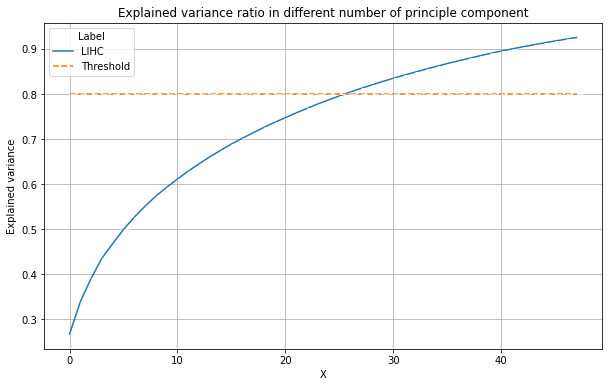

In [23]:
from sklearn.decomposition import PCA
sum_variance = np.concatenate((np.zeros(48),np.repeat(0.8,48)),axis = 0 )
for i in range(2,50) :
    pca = PCA(n_components=i)
    hbv_pca = pca.fit_transform(lihc_hbv)
    sum_variance[i-2] = sum(pca.explained_variance_ratio_)
df = pd.DataFrame({'Explained variance' : sum_variance,'X' : np.concatenate((np.arange(48),np.arange(48)),axis = 48),'Label' : (['LIHC']*48 + ['Threshold']*48) })
plt.figure(figsize=(10,6))
sns.lineplot(data = df ,x = 'X',y='Explained variance',hue = 'Label',style = 'Label',marker = True)
plt.grid()
plt.title('Explained variance ratio in different number of principle component')
plt.savefig(output_path + 'pca_explained_variance.png',dpi = 300)

In [35]:
from random import sample
pca = PCA(n_components=27)
hbv_pca = pca.fit_transform(lihc_hbv)

synthetic_data = np.zeros((103,27))
n = 0
for i in range(103) :
    ref = sample(list(np.arange(103)),2)
    r1 = hbv_pca[ref[0],:]
    r2 = hbv_pca[ref[1],:]
    synthetic_data[i,:] = (r1 + r2) / 2

In [ ]:
synthesis = pca.inverse_transform(synthetic_data)

id = ['Synthesized' +str(x) for x in range(103)]
synthesis_df = pd.DataFrame(synthesis,index=id)
synthesis_df.columns = lihc_df.columns
synthesis_df.to_csv(path + 'synthetic_data.txt',sep='\t')

lihc_stand_df = pd.DataFrame(lihc_df_stand.T,index = lihc_df.index)
lihc_stand_df.columns = lihc_df.columns

lihc_with_synthetic_df = pd.concat([lihc_stand_df,synthesis_df],axis= 0)
lihc_with_synthetic_df.to_csv(path+'lihc_coding_gene_exp_profile_with_synthesized_data_after_standardzation.txt',sep='\t')

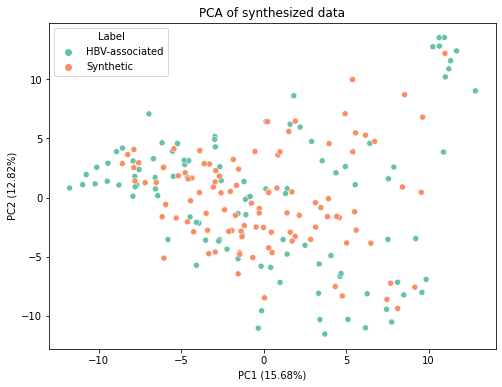

In [40]:
synthesis_array = np.concatenate((lihc_hbv,synthesis),axis=0)
pcaa = PCA(n_components=2)
syn_pca = pcaa.fit_transform(synthesis_array)
pca_df = pd.DataFrame({'PC1' : syn_pca[:,0],'PC2' : syn_pca[:,1],'Label' : (['HBV-associated']*103 +['Synthetic'] * 103)})
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='Label',palette="Set2")
plt.xlabel("PC1 (" + str(round(pcaa.explained_variance_ratio_[0]*100,2))+ "%)")
plt.ylabel("PC2 (" + str(round(pcaa.explained_variance_ratio_[1]*100,2)) + "%)")
plt.title('PCA of synthesized data')
plt.savefig(output_path + 'synthetic_data_pca.png',dpi = 300)

### ensemble result

In [106]:
#r_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/'
r_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic_data/'
prefix = 'lihc_ensemble_svm_with_synthetic'
lihc_with_synthetic_df = pd.read_csv(path+'lihc_coding_gene_exp_profile_with_synthesized_data_after_standardzation.txt',sep='\t',index_col=0)

In [17]:
def ensemble_result(result_path,prefix,threshold,ratio,n_sample,binary_flag = False) :

    p_r = np.zeros(n_sample)

    file_name = result_path + prefix + '_vote_np_ratio_'+str(ratio)+ '.npy'
    p_r = np.load(file_name)
    #transform vote number to binary 0/1
    if binary_flag :
            positive_idx = p_r >= threshold 
            p_r[positive_idx] = 1
            p_r[~positive_idx] = 0

    return p_r

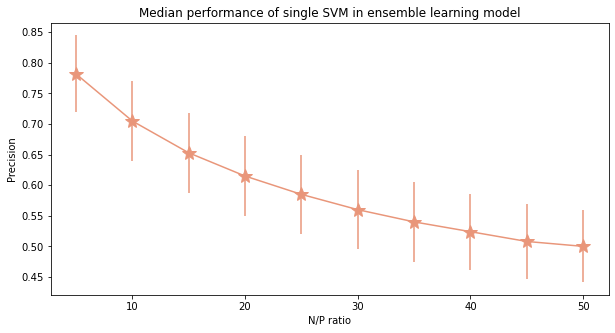

In [55]:
precision_median = np.zeros(10)
precision_std = np.zeros(10)
for idx,r in enumerate(np.arange(5,55,5)) :
    tet = np.load(r_path + "lihc_ensemble_svm_with_synthetic" + '_precision_np_ratio_'+str(r)+ '.npy')
    precision_median[idx] = round(np.median(tet),3)
    precision_std[idx] = round(np.std(tet),3)

plt.figure(figsize=(10,5))
plt.errorbar(np.arange(5,55,5),precision_median,yerr = precision_std,marker = '*', label='Precision',color = "darksalmon",ms = 15)
plt.ylabel('Precision')
plt.xlabel('N/P ratio')
plt.title('Median performance of single SVM in ensemble learning model')
plt.savefig(output_path + 'single_svm_performance_in_test.png',dpi = 300)

In [ ]:
ratio = np.arange(5,55,5)
result_path = r_path
vote_df = pd.DataFrame()
syn_id = ["Synthesized"+str(x) for x in range(103)]
pos_id = list(ens_id) + syn_id
pos_idx = [x in pos_id for x in lihc_with_synthetic_df.index]

for r in ratio :
    result = ensemble_result(result_path,'lihc_ensemble_svm_with_synthetic',0,r,19663)
    pos_vote = result[pos_idx]
    df = pd.DataFrame({'ID' : lihc_with_synthetic_df.index[pos_idx],'Ratio' : [r]*103*2,'Vote' : pos_vote})
    vote_df = pd.concat([vote_df,df],axis = 0)

plt.figure(figsize = (12,6))
p = sns.boxplot(data = vote_df,x = 'Ratio',y='Vote',palette = "rainbow")
p = sns.swarmplot(data = vote_df,x = 'Ratio',y='Vote',palette = "rainbow", color=".25")
plt.title('Ensemble learning model result of HBV-associated gene in different N/P ratio',fontsize = 15)
plt.xlabel('N/P ratio')
plt.savefig(output_path + "ensemble_vote_boxplot_after_data_augmentation.png",dpi = 300)

In [36]:
def gene_set_vote_number(gene_set,gene_list_of_ensemble_result,r_path,np_ratio,method = 'Mean') :
    
    n_gene = len(gene_list_of_ensemble_result)
    vote_array = np.zeros([len(gene_set),len(np_ratio)])
    for idx,r in enumerate(np_ratio) :
        result = ensemble_result(r_path,'lihc_ensemble_svm_with_synthetic',0,r,n_gene)
        gene_idx = [x in gene_set for x in gene_list_of_ensemble_result]
        gene_vote = result[gene_idx]
        vote_array[:,idx] = gene_vote
    if method == 'Mean' :
        vr = np.mean(vote_array,axis=1)
    elif method == 'Median' :
        vr = np.median(vote_array,axis = 1)

    return vr   

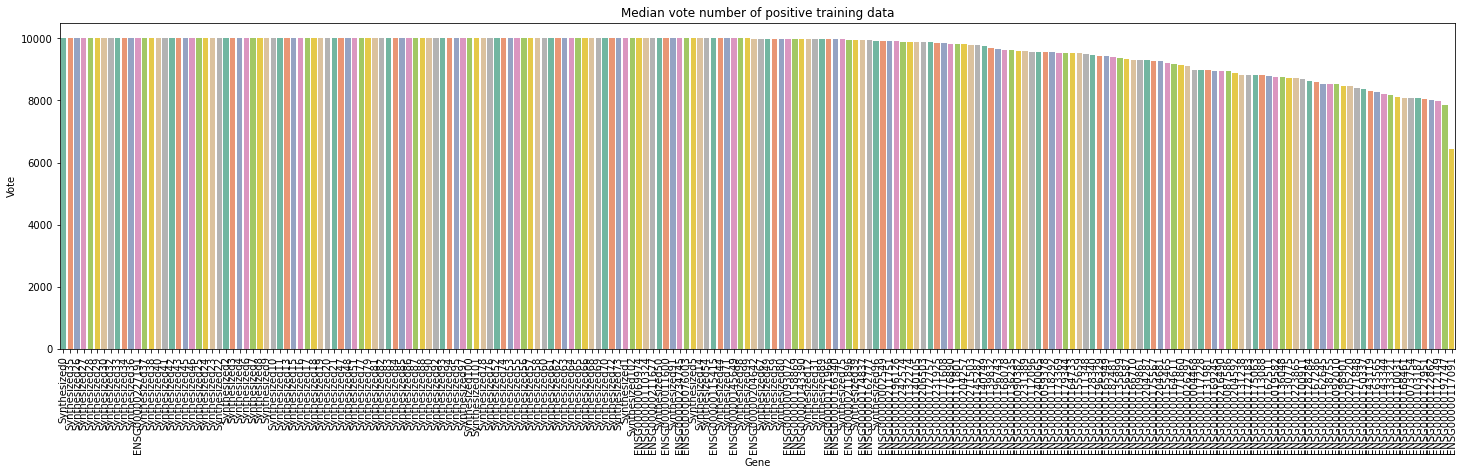

In [56]:
gs = pos_id
gl = lihc_with_synthetic_df.index
vrr = gene_set_vote_number(gs,gl,r_path,np.arange(5,55,5),method = 'Median')

df = pd.DataFrame({'Gene' : gs,'Vote' : vrr})
df = df.sort_values(by='Vote',ascending=False)
plt.figure(figsize=(25,6))
sns.barplot(data=df,x='Gene',y='Vote',palette="Set2")
plt.title("Median vote number of positive training data",fontsize = 12)
plt.xticks(rotation=90)
plt.savefig(output_path + "median_vote_number_of_ens_gene_with_synthetic.png",dpi = 300,bbox_inches = 'tight')

In [101]:
from sklearn.metrics import roc_auc_score,recall_score,precision_score

def grid_search_of_ensemble_vote_threshold(r_path,prefix,y,threshold,np_ratio):
    
    shape = (len(np_ratio),len(threshold))
    auc = np.zeros(shape)
    recall = np.zeros(shape)
    precision = np.zeros(shape)
    l = []

    for r_idx,r in enumerate(np_ratio) :
        for t_idx,t in enumerate(threshold) :
            y_pred = ensemble_result(r_path,prefix,t,r,19663,binary_flag=True)
            auc[r_idx,t_idx] = roc_auc_score(y,y_pred)
            recall[r_idx,t_idx] =  recall_score(y,y_pred)
            precision[r_idx,t_idx] =  precision_score(y,y_pred)

    return auc,recall,precision

def grid_search_for_ensemble_np(r_path,prefix,y,threshold,np_ratio) :

    auc = np.zeros(len(np_ratio))
    recall = np.zeros(len(np_ratio))
    precision = np.zeros(len(np_ratio))
    l = np.zeros(len(np_ratio))

    for idx,r in enumerate(np_ratio) :
        y_pred = ensemble_result(r_path,prefix,threshold,r,19663,binary_flag=True)
        auc[idx] = roc_auc_score(y,y_pred)
        recall[idx] =  recall_score(y,y_pred)
        precision[idx] =  precision_score(y,y_pred)
        l[idx] = int(r)

    l = list(l)
    return l,auc,recall,precision

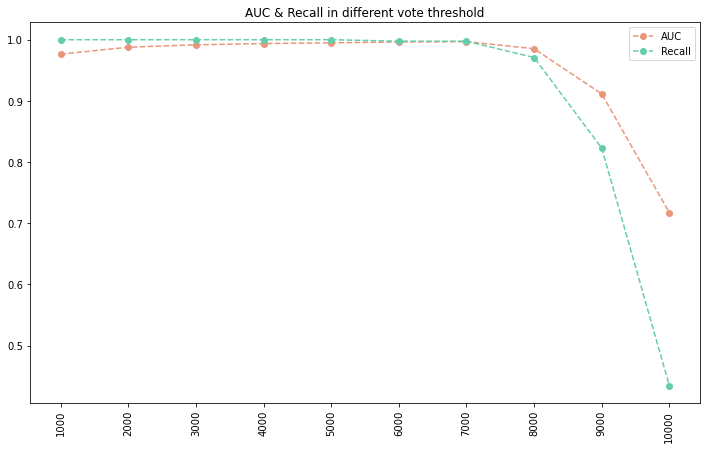

In [105]:
y = np.zeros(lihc_with_synthetic_df.shape[0])
pos_idx = [x in pos_id for x in lihc_with_synthetic_df.index]
y[pos_idx] = 1

th = np.arange(1000,11000,1000)
np_r = np.arange(5,55,5)
a,r,p = grid_search_of_ensemble_vote_threshold(r_path,'lihc_ensemble_svm_with_synthetic',y,th,np_r)

a = np.median(a,axis=0)
r = np.median(r,axis=0)
p = np.median(p,axis=0)

plt.figure(figsize=(12,7))
plt.plot(a, '--o', label='AUC',color = "darksalmon")
plt.plot(r,'--o',label = 'Recall',color = 'mediumaquamarine')
#plt.plot(p,'--o',label = 'Precision',color = 'lightcoral')
plt.xticks(np.arange(len(th)),th,rotation = 90)
plt.legend()
plt.title('AUC & Recall in different vote threshold')
plt.savefig(output_path + 'auc_recall_in_different_vote_threshold_with_synthetic.png',dpi = 300)


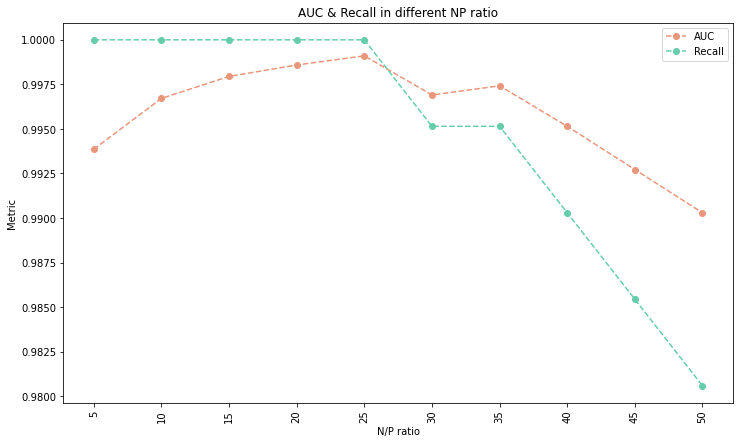

In [104]:
y = np.zeros(lihc_with_synthetic_df.shape[0])
pos_idx = [x in pos_id for x in lihc_with_synthetic_df.index]
y[pos_idx] = 1

th = 7000
np_r = np.arange(5,55,5)
l,a,r,p = grid_search_for_ensemble_np(r_path,'lihc_ensemble_svm_with_synthetic',y,th,np_r)

plt.figure(figsize=(12,7))
plt.plot(a, '--o', label='AUC',color = "darksalmon")
plt.plot(r,'--o',label = 'Recall',color = 'mediumaquamarine')
#plt.plot(p,'--o',label = 'Precision',color = 'lightcoral')

plt.xticks(np.arange(len(np_r)),np_r,rotation = 90)
plt.xlabel('N/P ratio')
plt.ylabel('Metric')
plt.legend()
plt.title('AUC & Recall in different NP ratio')
plt.savefig(output_path + 'auc_recall_in_different_np_ratio_with_synthetic.png',dpi = 300)

### Candidate gene

select candidate gene by ensemble result of following parameter : <br>
vote threshold : 700<br>
N/P ratio : 25

In [108]:
threshold = 7000
np_r = 25
y_pred = ensemble_result(r_path,prefix,threshold,np_r,19663,binary_flag=True)

In [117]:
pos_idx = y_pred == 1
pos_gene = list(lihc_with_synthetic_df.index[pos_idx])
candidate_gene = [item for item in pos_gene if item not in pos_id]
candidate_df = lihc_with_synthetic_df.loc[pos_idx,:]

Text(0.5, 1.0, 'PCA of HBV-associated gene & candidate gene (n=35)')

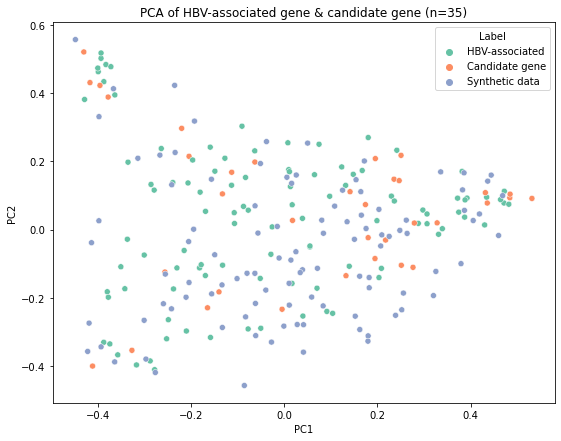

In [124]:
from sklearn.decomposition import PCA,KernelPCA

pca = KernelPCA(n_components=2,kernel='rbf')
candidate_pca = pca.fit_transform(candidate_df.to_numpy())
pca_df = pd.DataFrame()
pca_df['PC1'] = candidate_pca[:,0]
pca_df['PC2'] = candidate_pca[:,1]
pca_df['Label'] = ['HBV-associated']*len(pos_gene)
pca_df.index = pos_gene
pca_df.loc[candidate_gene,'Label'] = 'Candidate gene'
syn_idx = [bool(re.search('Synthesized',x)) for x in pca_df.index]
pca_df.loc[syn_idx,'Label'] = 'Synthetic data'
plt.figure(figsize=(9,7))
sns.scatterplot(data =pca_df,x = 'PC1',y='PC2',hue='Label',palette="Set2")
#plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2))+'%)' )
#plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2))+'%)' )
plt.title("PCA of HBV-associated gene & candidate gene (n=35)")
#plt.savefig(output_path + 'candidate_gene_pca_after_data_augmentation.png',dpi = 300)

In [71]:
candidate_df = pd.DataFrame({'ID' : pca_df.index,'Label' : pca_df['Label'].values})